# Technology focus: 10x Genomics Visium
This notebook will present a rough overview of the plotting functionalities that `spatialdata` implements for Visium data.

## Loading the data
Please download the data from here: [Visium dataset](https://s3.embl.de/spatialdata/spatialdata-sandbox/visium.zip) and rename it (eventually using symlinks) to `visium_brain.zarr`.


In [1]:
visium_zarr_path = "./visium_brain.zarr"

In [2]:
import spatialdata as sd

visium_sdata = sd.read_zarr(visium_zarr_path)
visium_sdata

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


SpatialData object with:
├── Images
│     ├── 'ST8059048_hires_image': SpatialImage[cyx] (3, 2000, 1969)
│     ├── 'ST8059048_lowres_image': SpatialImage[cyx] (3, 600, 591)
│     ├── 'ST8059050_hires_image': SpatialImage[cyx] (3, 2000, 1968)
│     └── 'ST8059050_lowres_image': SpatialImage[cyx] (3, 600, 590)
├── Shapes
│     ├── 'ST8059048': GeoDataFrame shape: (4992, 2) (2D shapes)
│     └── 'ST8059050': GeoDataFrame shape: (3497, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (8489, 31053)
with coordinate systems:
▸ 'ST8059048', with elements:
        ST8059048_hires_image (Images), ST8059048 (Shapes)
▸ 'ST8059050', with elements:
        ST8059050_hires_image (Images), ST8059050 (Shapes)

## Visualise the data
We're going to create a naiive visualisation of the data, overlaying the Visium spots and the tissue images. For this, we need to load the `spatialdata_plot` library which extends the `sd.SpatialData` object with the `.pl` module. 

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/spatialdata.py:155: UserWarning: The table is annotating 'ST8059048', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/spatialdata.py:155: UserWarning: The table is annotating 'ST8059048', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


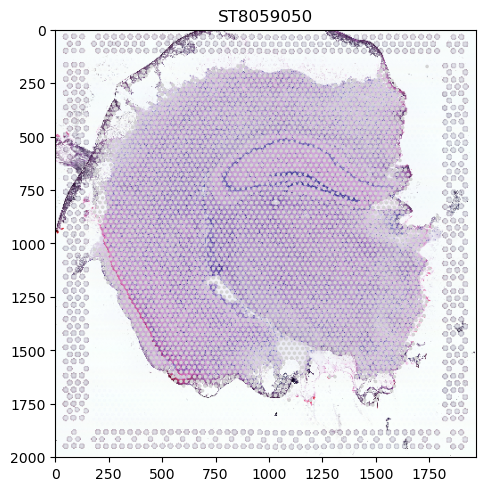

In [3]:
import spatialdata_plot

visium_sdata.pl.render_images().pl.render_shapes().pl.show("ST8059050")

We can see that the data contains two coordinate systems (`ST8059050` and `ST8059052`) with image and spot information each. In `SpatialData`, these spots are represented as `Shapes`. When giving no further parameters, one panel is generated per coordinate system with the members that have been specified in the function call. We can see that the spots are aligned to the tissue representation which is also respected by the plotting logic.

However, the spots are all grey since we have not provided any information on what they should encode. Such information can be found in the `Table` attribute (which is an `anndata.AnnData` table) of the `SpatialData` object, either in the data itself or the `obs` attribute.

In [4]:
visium_sdata["table"].to_df().sum(axis=0).sort_values(ascending=False).head(10)
# We will select some of the highly expressed genes for this example

mt-Co3     3366555.0
mt-Co1     3134006.0
mt-Atp6    2175621.0
mt-Co2     2160662.0
mt-Cytb    1317073.0
mt-Nd4     1100399.0
mt-Nd1     1098630.0
Fth1        840543.0
Ttr         833197.0
mt-Nd2      775515.0
dtype: float32

In [5]:
visium_sdata["table"].obs.head(3)

,in_tissue,array_row,array_col,spot_id,region
AAACAACGAATAGTTC-1,0,0,16,0,ST8059048
AAACAAGTATCTCCCA-1,1,50,102,1,ST8059048
AAACAATCTACTAGCA-1,0,3,43,2,ST8059048


### Color the visium spots by gene expression
To use this information in our plot, we pass the name of the column by which we want to color our expression to `color`. Furthermore, we are going to subset the data to only one coordinate system.

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/spatialdata.py:155: UserWarning: The table is annotating 'ST8059048', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:112: UserWarning: Key `table` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/spatialdata.py:155: UserWarning: The table 

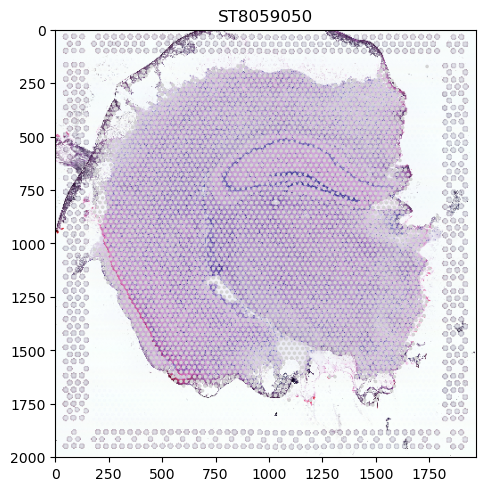

In [6]:
(
    visium_sdata.pp.get_elements("ST8059050")
    .pl.render_images(elements="ST8059050_hires_image")
    .pl.render_shapes(elements="ST8059050", color="mt-Co3")
    .pl.show()
)

We can also provide `ax` objects to `spatialdata_plot` for further customisation.

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/spatialdata.py:155: UserWarning: The table is annotating 'ST8059048', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:112: UserWarning: Key `table` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/spatialdata.py:155: UserWarning: The table 

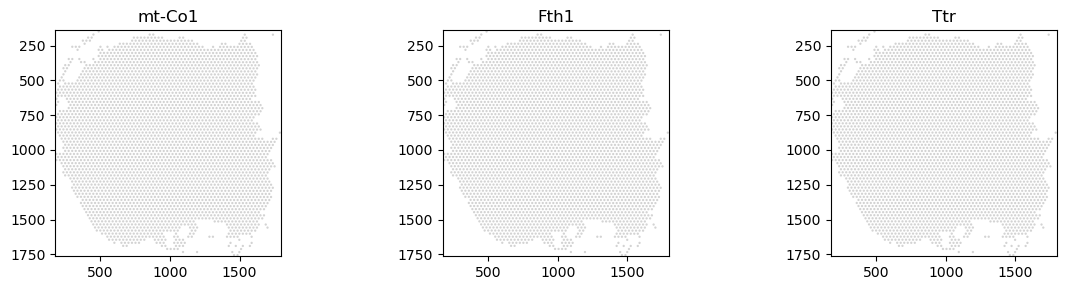

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 3))

visium_sdata_subset = visium_sdata.pp.get_elements("ST8059050")

visium_sdata_subset.pl.render_shapes(elements="ST8059050", color="mt-Co1").pl.show(ax=axs[0], title="mt-Co1")

visium_sdata_subset.pl.render_shapes(elements="ST8059050", color="Fth1").pl.show(ax=axs[1], title="Fth1")

visium_sdata_subset.pl.render_shapes(elements="ST8059050", color="Ttr").pl.show(ax=axs[2], title="Ttr")

plt.tight_layout()